In [1]:
import re, os
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment

from wordcloud import WordCloud

from acquire_c import *
from prepare_c import *
from explore_c import *

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

## Acquire data and find the dominant language in each row

In [21]:
# You can pass a threshold argument but the default is 75
lang = 'java'
not_lang = f'not_{lang}'
df = get_readme_data(lang=lang, lang_threshold=90)
df.prog_lang.value_counts()

Did not find the file java_clean_readme_90_z0_5.csv
cleaning data, hold your horses....
cleaning the orginial data
Removing words who's zscore falls below the cutoff, this will take a moment
calculating word counts, please wait...
Before: 26357 words in the dataframe
After: 1399 words will remain
Removing the words from the column
stemming the reduced cleaned data


/Users/charlesatchison/codeup-data-science/NLP-Project/prepare_c.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = df['cleaned'].apply(stem)


lemmatizing the reduced claned data


/Users/charlesatchison/codeup-data-science/NLP-Project/prepare_c.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized'] = df['cleaned'].apply(lemmatize)


Removing words who's zscore falls below the cutoff, this will take a moment
calculating word counts, please wait...
Before: 172616 words in the dataframe
After: 3636 words will remain
Removing the words from the column
stemming the reduced cleaned data


/Users/charlesatchison/codeup-data-science/NLP-Project/prepare_c.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = df['cleaned'].apply(stem)


lemmatizing the reduced claned data


/Users/charlesatchison/codeup-data-science/NLP-Project/prepare_c.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized'] = df['cleaned'].apply(lemmatize)


saved file: java_clean_readme_90_z0_5.csv


Python         3666
JavaScript     1925
Java            930
HTML            466
C++             401
               ... 
Common Lisp       1
Pony              1
VBA               1
EJS               1
DM                1
Name: prog_lang, Length: 89, dtype: int64

In [3]:
java_obj = NLP_explore(df, 'label', 'cleaned', lang, not_lang)

## Explore

### Look at word freqencies for JavaScript
|          |   word_count |
|:---------|-------------:|
| data     |        25128 |
| use      |        20312 |
| gt       |        19874 |
| yes      |        19795 |
| code     |        18020 |
| python   |        17961 |
| using    |        17762 |
| top      |        16057 |
| project  |        15087 |
| 1        |        13589 |
| run      |        13366 |
| api      |        12797 |
| unknown  |        12742 |
| github   |        12660 |
| file     |        12109 |
| learning |        11736 |
| open     |        11354 |
| app      |        11260 |
| create   |        10836 |
| 2        |        10439 |

In [4]:
# print(pd.DataFrame({'word_count': java_obj.all_freq}).head(20).to_markdown())

## Look at some word count visualizations

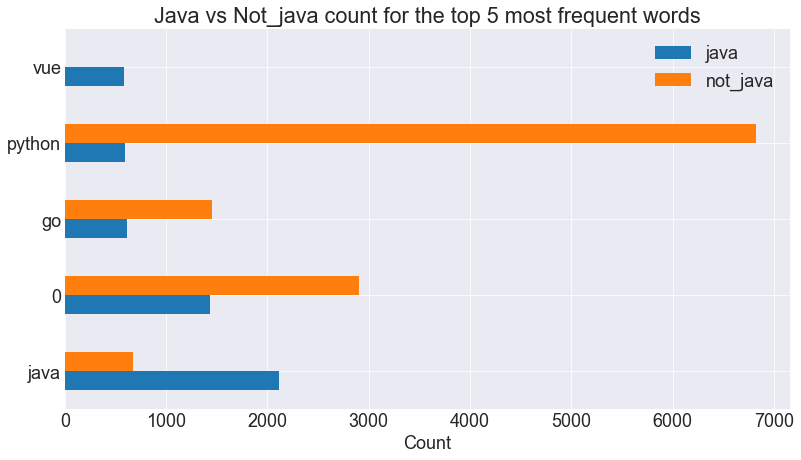

<Figure size 1152x648 with 0 Axes>

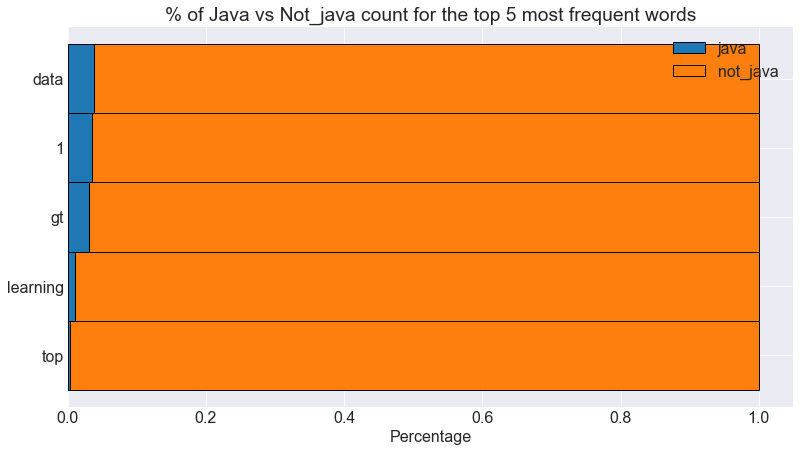

In [5]:
# Looking at just JavaScript hplot
java_obj.hplot_word_freq_viz(n=5, sort=lang)
# Looking at just JavaScript bplot stacked
java_obj.stacked_bplot_freq(n=5, sort=not_lang)

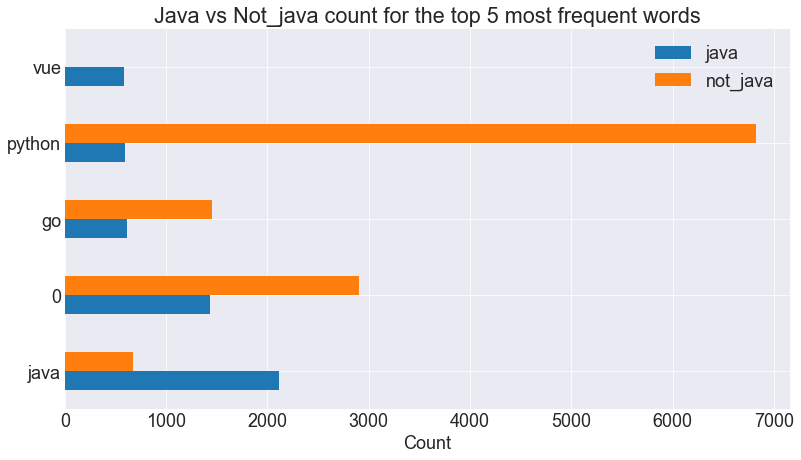

<Figure size 1152x648 with 0 Axes>

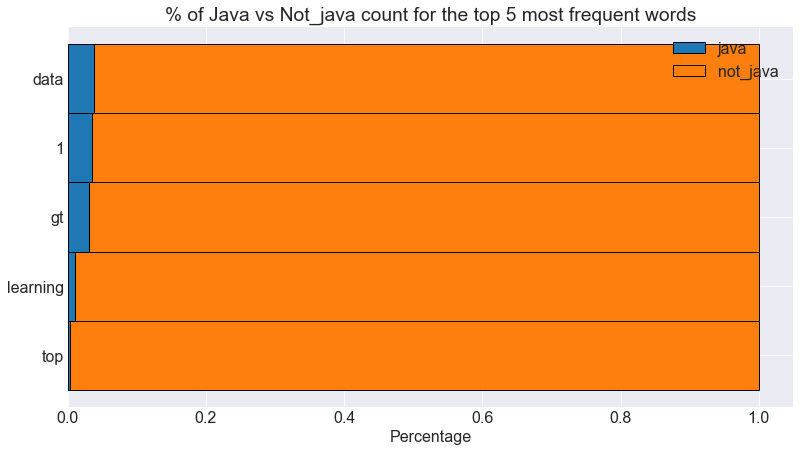

In [6]:
# Looking at just not_JavaScript hplot
java_obj.hplot_word_freq_viz(n=5, sort=lang)
# Looking at just not_JavaScript bplot stacked
java_obj.stacked_bplot_freq(n=5, sort=not_lang)

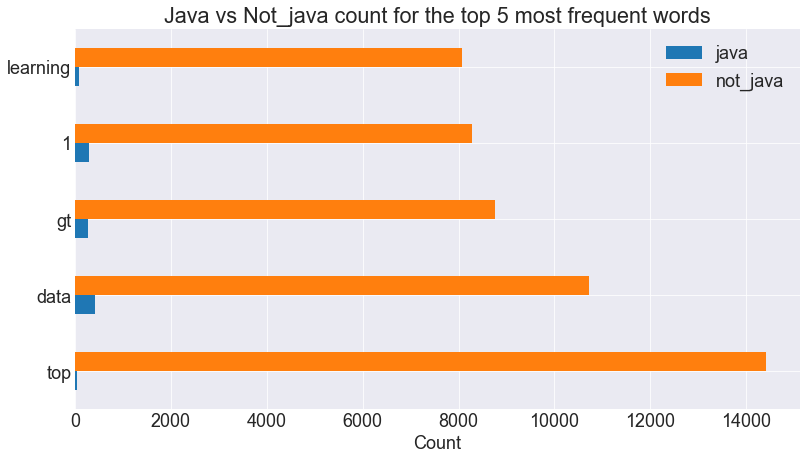

<Figure size 1152x648 with 0 Axes>

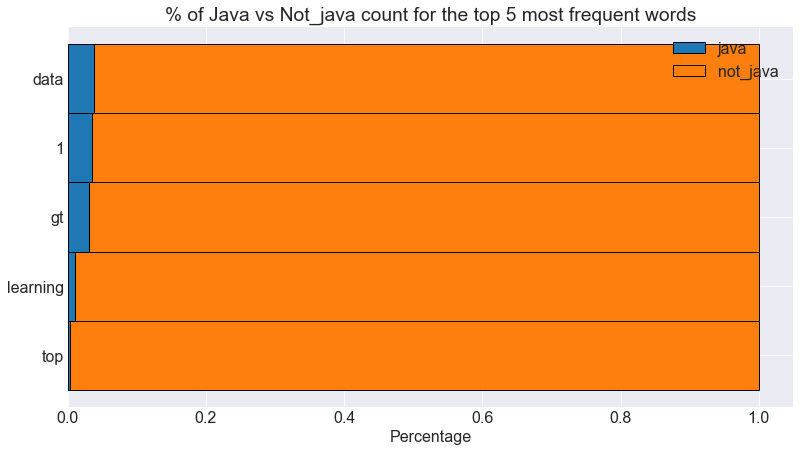

In [7]:
# Looking at just all hplot
java_obj.hplot_word_freq_viz(n=5)
# Looking at just all bplot stacked
java_obj.stacked_bplot_freq(n=5)

## Look at N-Grams Visualizations

### Look at Bigrams

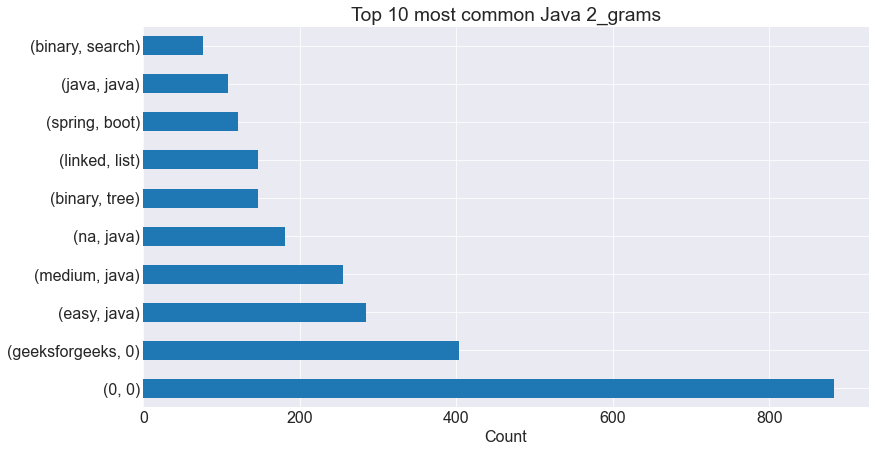

In [8]:
java_bigram = java_obj.n_gram(top_n= 10, col=lang)

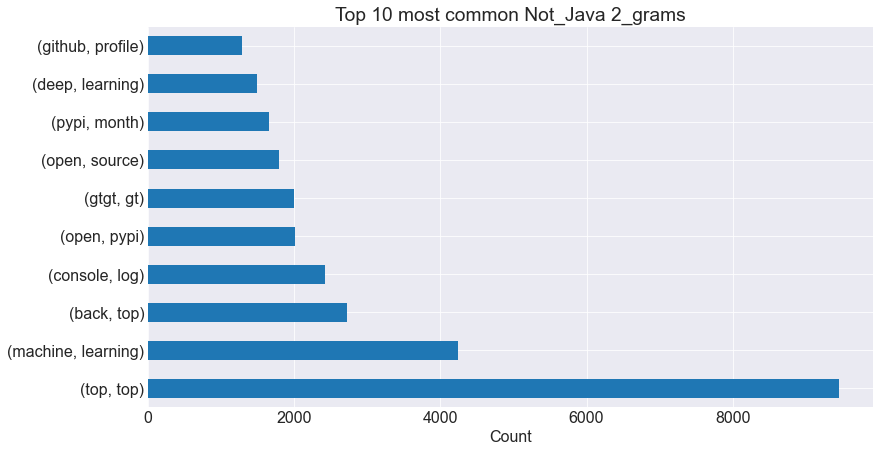

In [9]:
not_java_bigram = java_obj.n_gram(top_n = 10, col=not_lang)

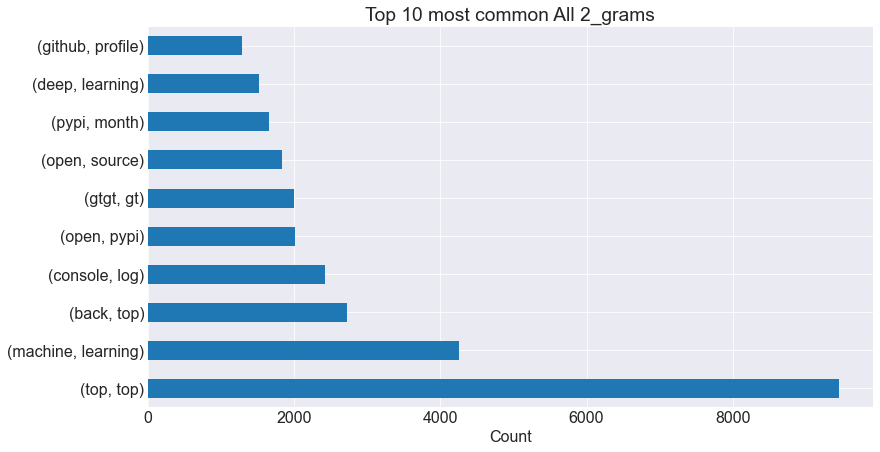

In [10]:
both_bigrams = java_obj.n_gram(top_n=10)

### Look at trigrams

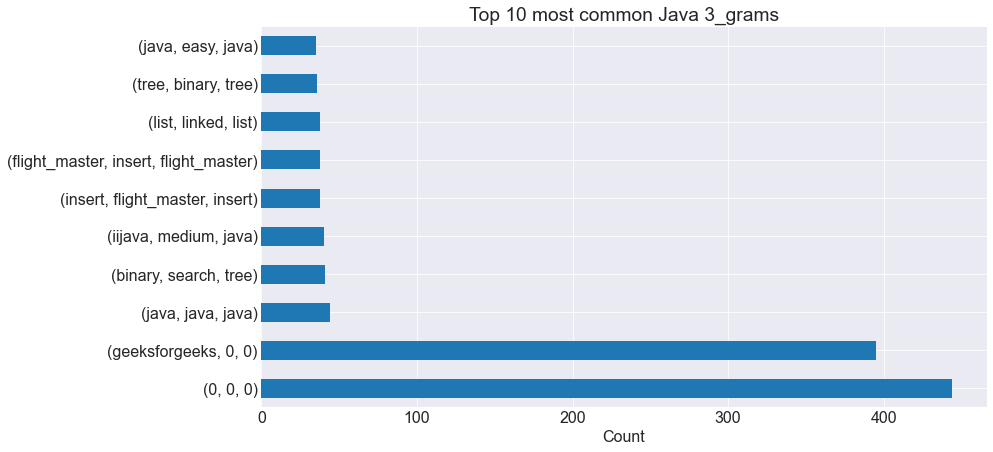

In [11]:
java_trigram = java_obj.n_gram(n=3, top_n=10, col=lang)

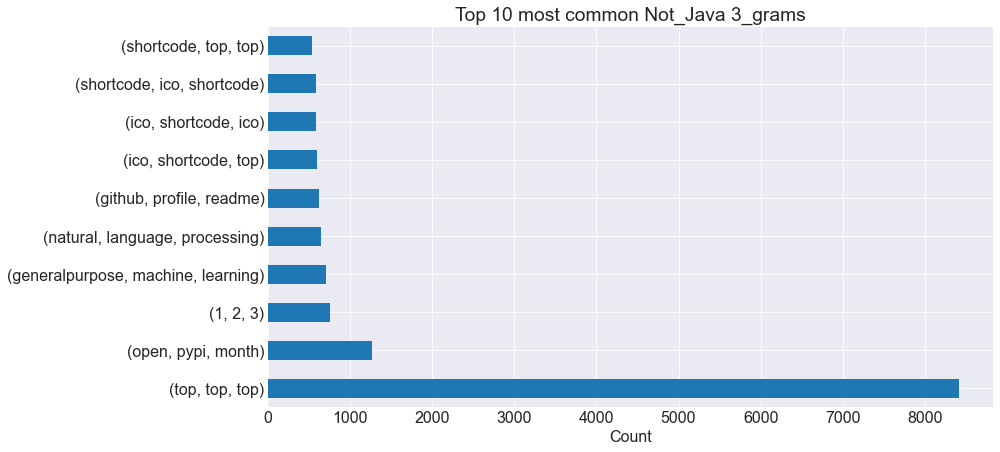

In [12]:
not_java_trigram = java_obj.n_gram(n=3, top_n=10, col=not_lang)

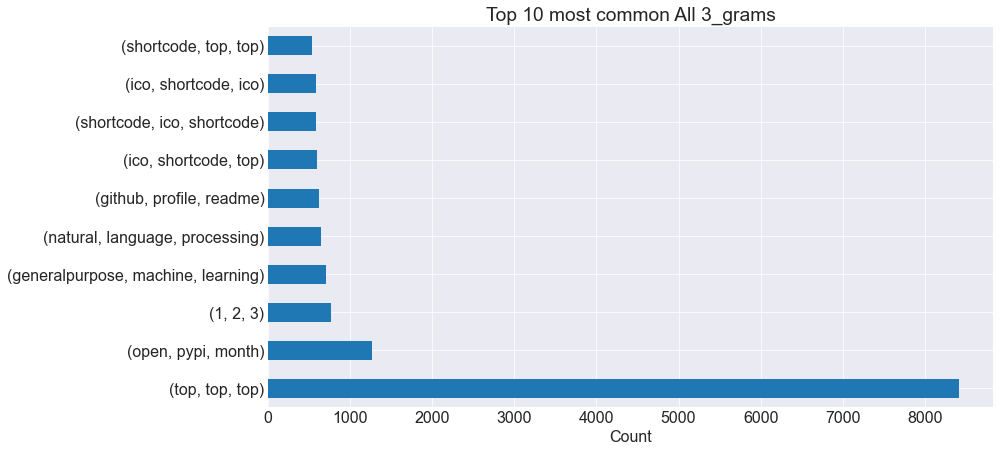

In [13]:
all_trigram = java_obj.n_gram(n=3, top_n=10)

### Plot some wordclouds

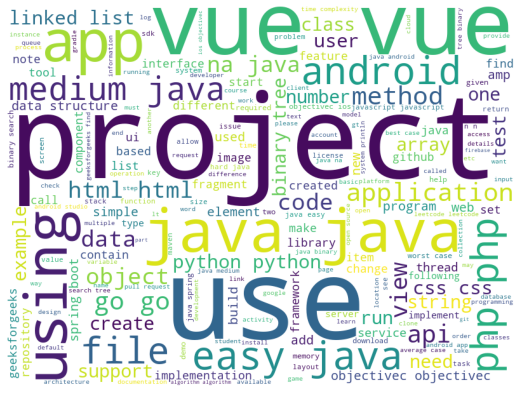

In [14]:
java_obj.plot_wordcloud(col=lang)

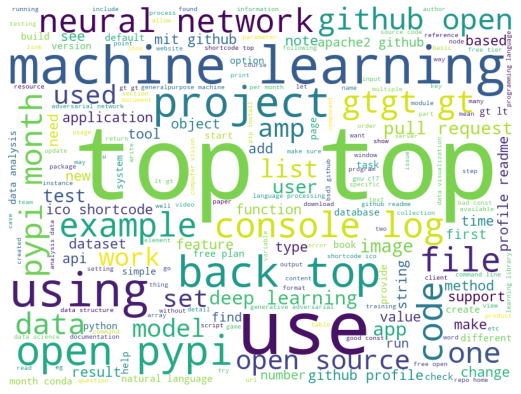

In [15]:
java_obj.plot_wordcloud(col=not_lang)

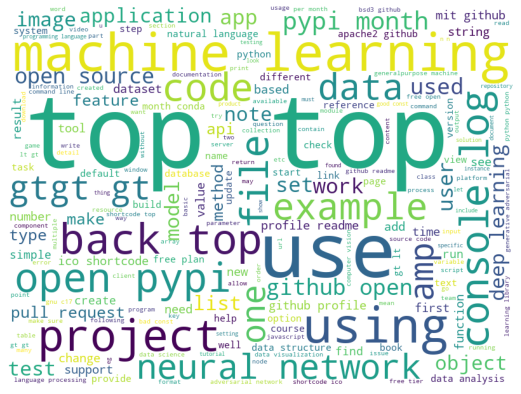

In [16]:
java_obj.plot_wordcloud()

## Add some sentiment analysis and some features

In [17]:
# Add sentiment analysis
java_obj.add_sentiment_analysis()
# Add features
java_obj.add_features()

java_obj.df.head()

,prog_lang,original,cleaned,label,stemmed,lemmatized,neg,neu,pos,compound,message_length,word_count,unique_word_count,avg_word_len
10,Java,###THIS IS THE PLACE TO HONE YOUR PROGRAMMING ...,programming level language,java,program level languag,programming level language,0.0,1.000,0.000,0.0000,26,3,"{'programming': 1, 'language': 1, 'level': 1}",8.67
11,Java,Spring Framework 5: Beginner to Guru This repo...,spring framework 5 repository example applicat...,java,spring framework 5 repositori exampl applic bu...,spring framework 5 repository example applicat...,0.0,0.876,0.124,0.9831,1658,250,"{'spring': 35, 'framework': 18, 'course': 13, ...",6.63
33,Java,code-quality-n2d This is a test repo for code ...,test repo code,java,test repo code,test repo code,0.0,1.000,0.000,0.0000,14,3,"{'code': 1, 'repo': 1, 'test': 1}",4.67
54,Java,PetShop PetShop app,app,java,app,app,0.0,1.000,0.000,0.0000,3,1,{'app': 1},3.00
55,Java,ServiceApp(underDevelopment) This application ...,application help user local get done like serv...,java,applic help user local get done like servic se...,application help user local get done like serv...,0.0,0.743,0.257,0.6369,124,17,"{'services': 3, 'application': 2, 'local': 2, ...",7.29


## Sentiment analysis bivariate plots

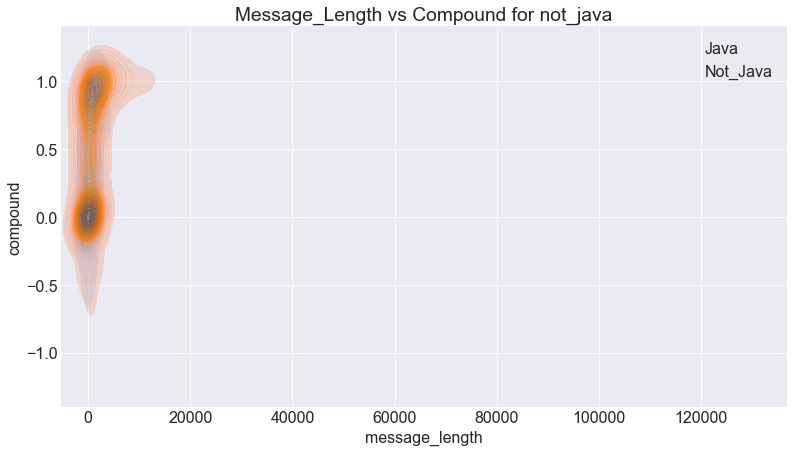

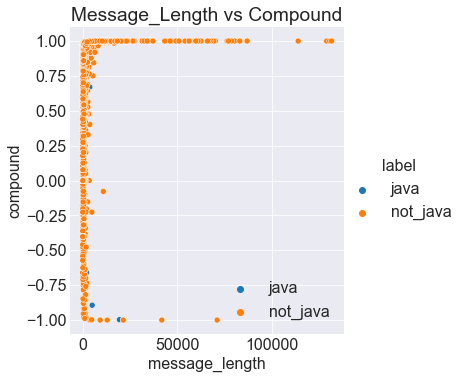

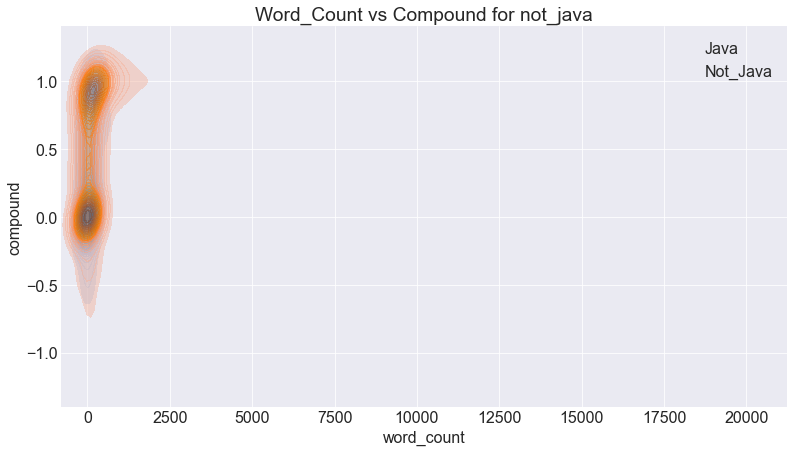

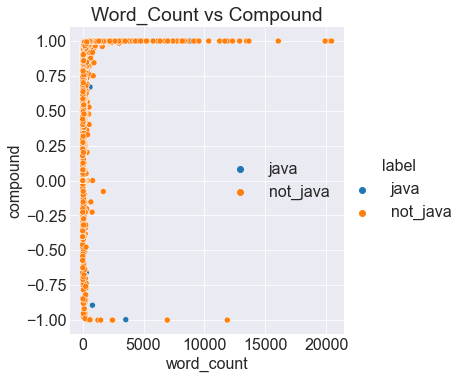

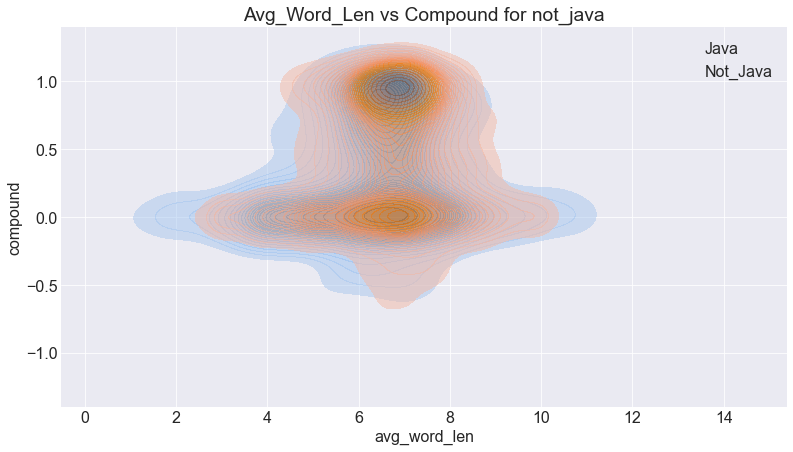

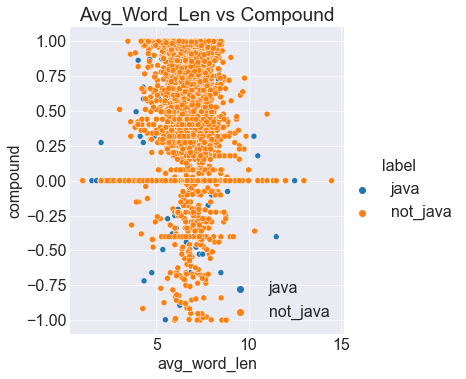

In [18]:
java_obj.sentiment_bivariate_plots()

## Sentiment distribution plots

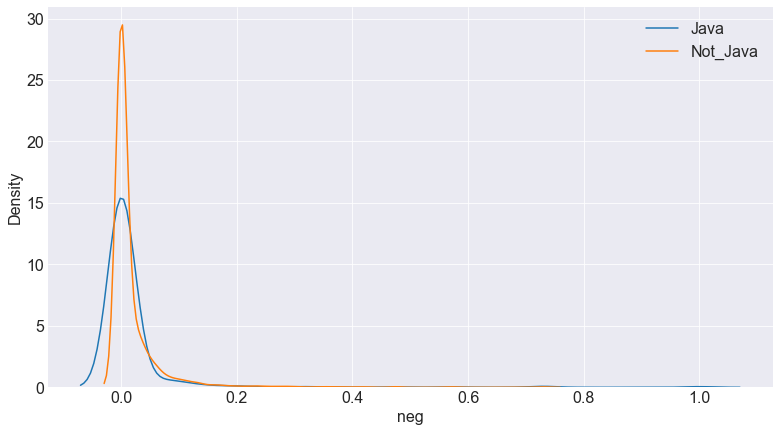

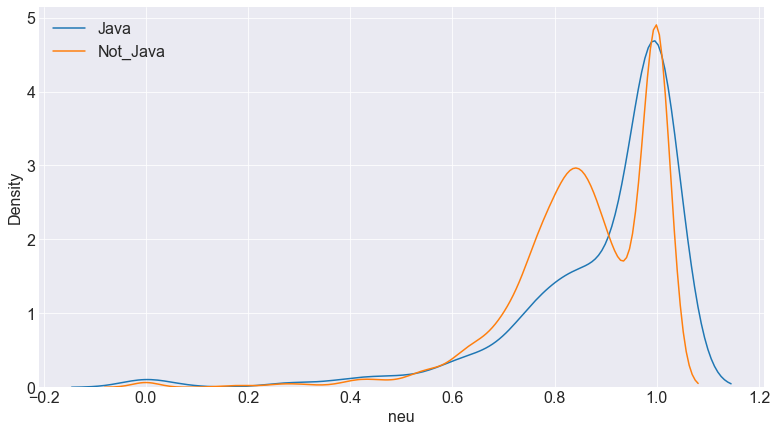

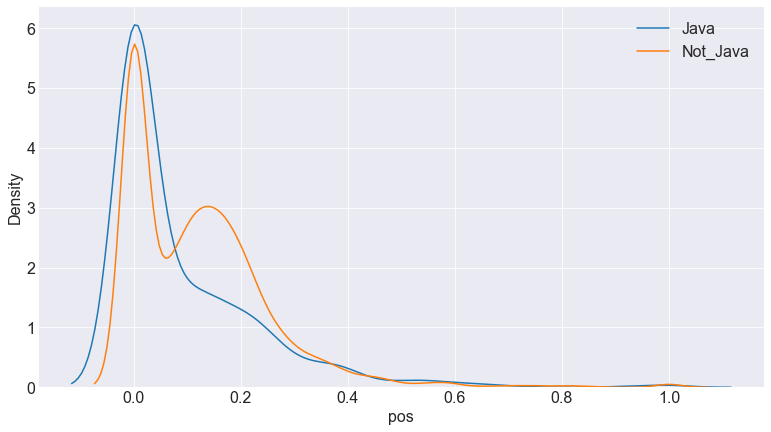

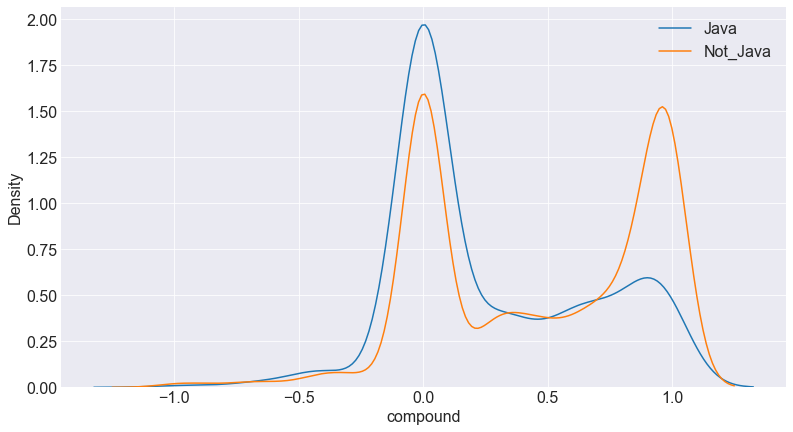

In [19]:
java_obj.sentiment_distributions()

In [20]:
%%html
<style>
table {margin-left: 0 !important;}
</style>